In [1]:
using Pkg
ENV["JULIA_REVISE_POLL"]=1
using Revise
Pkg.activate("/home/rjacobse/.julia/dev/WVZAnalysis/")
using WVZAnalysis

  Activating project at `~/.julia/dev/WVZAnalysis`


In [2]:
WVZAnalysis.ANALYSIS_DIR[]="/data/jiling/WVZ/v2.3_hists_uproot_jan16"
using ProgressMeter, PrettyTables, UnROOT, FHist, JSON3, CairoMakie, ThreadsX, Measurements, Distributions, Formatting,Serialization,LaTeXStrings,FileIO
CairoMakie.activate!(px_per_unit=2)

In [3]:
#loads pre-minitree data
DSIDs = Dict()
names = ["Signal","ZZ","WZ","Zjets","Zgamma","ttZ","tZ","tWZ","ttbar","VBS","VH","Others",
    "Signal_WWZ_4l2v","Signal_WWZ_2l4v","Signal_WZZ_5l1v","Signal_WZZ_3l3v","Signal_ZZZ_6l0v",
    "Signal_ZZZ_4l2v","Signal_ZZZ_2l4v","Signal_ZZZ_4l2j","Signal_WWZ_3l1v2j","Signal_WZZ_4l2j","Signal_WZZ_3l1v2j"]
for process in names
    DSIDs[process]=String[]
    for i in prep_tasks(process)
        push!(DSIDs[process],i.path[findfirst("3sf", i.path)[2]+3:findfirst("3sf", i.path)[2]+8])
    end
    DSIDs[process]=unique(DSIDs[process])
end

CSDict=Dict()
names = ["Signal","ZZ","WZ","Zjets","Zgamma","ttZ","tZ","tWZ","ttbar","VBS","VH","Others",
    "Signal_ZZZ_6l0v","Signal_WZZ_5l1v","Signal_ZZZ_4l2v","Signal_ZZZ_4l2j","Signal_WWZ_4l2v","Signal_WZZ_4l2j",
    "Signal_WWZ_3l1v2j","Signal_WZZ_3l1v2j","Signal_WZZ_3l3v","Signal_WWZ_2l4v","Signal_ZZZ_2l4v"]
namessignal=["Signal_ZZZ_6l0v",
             "Signal_WZZ_5l1v",
             "Signal_ZZZ_4l2v",
             "Signal_ZZZ_4l2j",
             "Signal_WWZ_4l2v",
             "Signal_WZZ_4l2j",
             "Signal_WWZ_3l1v2j",
             "Signal_WZZ_3l1v2j",
             "Signal_WZZ_3l3v",
             "Signal_WWZ_2l4v",
             "Signal_ZZZ_2l4v"]
namesmain=["Signal","ZZ","Zjets","WZ","Zgamma","ttZ","tZ","tWZ","ttbar","VBS","VH","Others"]
for name in names
    CSDict[name]=[]
    directory = "/data/jiling/WVZ/v2.3/"
    for DSID in DSIDs[name]
        for folder in collect(Iterators.filter(x-> occursin("3sf",x), readdir(directory)))
            if occursin(DSID,folder)
                file = collect(readdir(directory*folder))[2]
                r=ROOTFile(directory*folder*"/"*file)
                push!(CSDict[name],(UnROOT.parseTH(r["xs"])[2][1][1]+1)*(UnROOT.parseTH(r["lumi"])[2][1][1]+1))
            end
        end
    end
   println(name,": ",string(round(sum(CSDict[name]),digits=2)))
end

Signal: 2408.55
ZZ: 684360.32
WZ: 1.52378111e6
Zjets: 9.2645617922e8
Zgamma: 2.754644561e7
ttZ: 110273.6
tZ: 33408.62
tWZ: 2233.31
ttbar: 1.068584851e7
VBS: 22866.61
VH: 236632.71
Others: 2.179698941e7
Signal_ZZZ_6l0v: 2.02
Signal_WZZ_5l1v: 26.14
Signal_ZZZ_4l2v: 12.01
Signal_ZZZ_4l2j: 41.66
Signal_WWZ_4l2v: 249.66
Signal_WZZ_4l2j: 54.32
Signal_WWZ_3l1v2j: 1040.54
Signal_WZZ_3l1v2j: 362.11
Signal_WZZ_3l3v: 103.44
Signal_WWZ_2l4v: 492.87
Signal_ZZZ_2l4v: 23.79


In [4]:
#loads cutflow histograms, either from prerendered files or directly from mainlooper
prerendered=true
if prerendered
    cutflows=Dict()
    cutflowswgt=Dict()
    SFinZcutflows=Dict()
    SFinZcutflowswgt=Dict()
    SFnoZcutflows=Dict()
    SFnoZcutflowswgt=Dict()
    DFcutflows=Dict()
    DFcutflowswgt=Dict()
    for process in names
        t = time()
        println("On process ",process)
        processdict=deserialize("/data/jiling/WVZ/v2.3_hists_uproot_jan16/"*process*".jlserialize")
        cutflows[process]=processdict[:CutFlow]
        cutflowswgt[process]=processdict[:CutFlowWgt]
        SFinZcutflows[process]=processdict[:SFinZCutFlow]
        SFinZcutflowswgt[process]=processdict[:SFinZCutFlowWgt]
        SFnoZcutflows[process]=processdict[:SFnoZCutFlow]
        SFnoZcutflowswgt[process]=processdict[:SFnoZCutFlowWgt]
        DFcutflows[process]=processdict[:DFCutFlow]
        DFcutflowswgt[process]=processdict[:DFCutFlowWgt]
        println("Seconds elapsed: ",time()-t)
    end
else
    cutflows=Dict()
    cutflowswgt=Dict()
    SFinZcutflows=Dict()
    SFinZcutflowswgt=Dict()
    SFnoZcutflows=Dict()
    SFnoZcutflowswgt=Dict()
    DFcutflows=Dict()
    DFcutflowswgt=Dict()
    for process in namessignal
        t = time()
        println("On process ",process)
        processdict=ThreadsX.map(x->main_looper(x), prep_tasks(process))
        processdict=reduce(mergewith(+), processdict)
        cutflows[process]=processdict[:CutFlow]
        cutflowswgt[process]=processdict[:CutFlowWgt]
        SFinZcutflows[process]=processdict[:SFinZCutFlow]
        SFinZcutflowswgt[process]=processdict[:SFinZCutFlowWgt]
        SFnoZcutflows[process]=processdict[:SFnoZCutFlow]
        SFnoZcutflowswgt[process]=processdict[:SFnoZCutFlowWgt]
        DFcutflows[process]=processdict[:DFCutFlow]
        DFcutflowswgt[process]=processdict[:DFCutFlowWgt]
        println("Seconds elapsed: ",time()-t)
    end
end

On process Signal
Seconds elapsed: 0.2719550132751465
On process ZZ
Seconds elapsed: 0.010051965713500977
On process WZ
Seconds elapsed: 0.009187936782836914
On process Zjets
Seconds elapsed: 0.008946895599365234
On process Zgamma
Seconds elapsed: 0.008884906768798828
On process ttZ
Seconds elapsed: 0.10095405578613281
On process tZ
Seconds elapsed: 0.009172201156616211
On process tWZ
Seconds elapsed: 0.00896000862121582
On process ttbar
Seconds elapsed: 0.008709907531738281
On process VBS
Seconds elapsed: 0.00884699821472168
On process VH
Seconds elapsed: 0.008931875228881836
On process Others
Seconds elapsed: 0.009016990661621094
On process Signal_ZZZ_6l0v
Seconds elapsed: 0.008950948715209961
On process Signal_WZZ_5l1v
Seconds elapsed: 0.010590791702270508
On process Signal_ZZZ_4l2v
Seconds elapsed: 0.009057998657226562
On process Signal_ZZZ_4l2j
Seconds elapsed: 0.008996009826660156
On process Signal_WWZ_4l2v
Seconds elapsed: 0.008955001831054688
On process Signal_WZZ_4l2j
Seconds 

In [5]:
#loads information for tables
wgthists=Dict()
for process in names
    wgthists[process]=cutflowswgt[process]
    wgthists[process]+=SFinZcutflowswgt[process]
    wgthists[process]+=SFnoZcutflowswgt[process]
    wgthists[process]+=DFcutflowswgt[process]
end
nowgthists=Dict()
for process in names
    nowgthists[process]=cutflows[process]
    nowgthists[process]+=SFinZcutflows[process]
    nowgthists[process]+=SFnoZcutflows[process]
    nowgthists[process]+=DFcutflows[process]
end
variable = :cut
backgrounds=namesmain[2:end]
cuts = ["Original","Minitree","Trigger","Nlep != 4","Zmass","W quality","Isolation","Mll","Pt",raw"$\Delta$ R","MET","B veto"]
totvalues = Dict()
sigvalues=Dict()
colnames=["Yield after cut","Yield removed",raw"Inclusive \%",raw"Exclusive \%",raw"\# of entries"]
numcuts=12
cutvalues=Dict()
for process in namesmain
    cutvalues[process]=[]
    push!(cutvalues[process],sum(CSDict[process]))
    for bin in 1:numcuts-1
        push!(cutvalues[process],sum(bincounts(wgthists[process])[bin:numcuts]))
    end
end
for colname in colnames
    totvalues[colname]=[]
    for bin in 1:numcuts
        if colname=="Yield after cut"
            push!(totvalues[colname],format(round(mapreduce(x->cutvalues[x],+,backgrounds)[bin],digits=2), commas=true))
        elseif colname=="Yield removed"
            if bin != 1
                push!(totvalues[colname],format(round(-mapreduce(x->cutvalues[x],+,backgrounds)[bin]+mapreduce(x->cutvalues[x],+,backgrounds)[bin-1],digits=2), commas=true))
            else
                push!(totvalues[colname],0)
            end
        elseif colname==raw"Inclusive \%"
            if bin != 1
                push!(totvalues[colname],string(round(100*mapreduce(x->cutvalues[x],+,backgrounds)[bin]/mapreduce(x->cutvalues[x],+,backgrounds)[1],digits=4))*raw"\%")
            else
                push!(totvalues[colname],raw"100\%")
            end
        elseif colname==raw"Exclusive \%"
            if bin != 1
                push!(totvalues[colname],string(round(100*mapreduce(x->cutvalues[x],+,backgrounds)[bin]/mapreduce(x->cutvalues[x],+,backgrounds)[bin-1],digits=2))*raw"\%")
            else
                push!(totvalues[colname],raw"100\%")
            end
        else
            if bin == 1
                push!(totvalues[colname],raw"N/A")
            else
                push!(totvalues[colname],format(mapreduce(x->sum(bincounts(nowgthists[x])[bin-1:numcuts]),+,backgrounds),commas=true))
            end
        end
    end
end

for colname in colnames
    sigvalues[colname]=[]
    for bin in 1:numcuts
        if colname=="Yield after cut"
            push!(sigvalues[colname],format(round(cutvalues["Signal"][bin],digits=2), commas=true))
        elseif colname=="Yield removed"
            if bin != 1
                push!(sigvalues[colname],format(round(-cutvalues["Signal"][bin]+cutvalues["Signal"][bin-1],digits=2), commas=true))
            else
                push!(sigvalues[colname],0)
            end
        elseif colname==raw"Inclusive \%"
            if bin != 1
                push!(sigvalues[colname],string(round(100*cutvalues["Signal"][bin]/cutvalues["Signal"][1],digits=4))*raw"\%")
            else
                push!(sigvalues[colname],raw"100\%")
            end
        elseif colname==raw"Exclusive \%"
            if bin != 1
                push!(sigvalues[colname],string(round(100*cutvalues["Signal"][bin]/cutvalues["Signal"][bin-1],digits=2))*raw"\%")
            else
                push!(sigvalues[colname],raw"100\%")
            end
        else
            if bin == 1
                push!(sigvalues[colname],raw"N/A")
            else
                push!(sigvalues[colname],format(sum(bincounts(nowgthists["Signal"])[bin-1:numcuts]),commas=true))
            end
        end
    end
end

Cutflow tables for signal and background:

In [6]:
fancynames=["VVZ","ZZ","Z+jets",raw"Z+\gamma","tt","WZ","tZ","ttZ","tWZ","VBS","VH","others"]
println(raw"""
\begin{table}[!htbp]
\centering
\begin{tabular}{c|c|c|c}
\hline \hline
Process    & 4$\ell$-SF-inZ    & 4$\ell$-SF-noZ   & 4$\ell$-DF     \\
\hline \hline""")
tab=significance_table(recreate=false)
for i in 1:12
    print(fancynames[i])
    for j in 2:4
        print(" & ")
        print(round(tab[i,j],digits=2))
    end
    println(raw"\\ ")
end
println(raw"\hline")
print("tot. MC")
for j in 2:4
    print(" & ")
    print(round(sum(tab[2:12,j]),digits=2))
end
println(raw"\\ ")
println(raw"""
\hline \hline
\end{tabular}
\caption{Expected yields in the $4\ell$ channel for $139\;\textrm{fb}^{-1}$ using the nominal MC samples. Only statistical uncertainties are shown.}
\label{tab:4l_selection_yields}
\end{table}
""")

\begin{table}[!htbp]
\centering
\begin{tabular}{c|c|c|c}
\hline \hline
Process    & 4$\ell$-SF-inZ    & 4$\ell$-SF-noZ   & 4$\ell$-DF     \\
\hline \hline
VVZ & 10.59 ± 0.07 & 9.04 ± 0.1 & 10.53 ± 0.14\\ 
ZZ & 1213.4 ± 5.4 & 326.7 ± 2.2 & 18.15 ± 0.44\\ 
Z+jets & -0.02 ± 0.13 & 2.2 ± 2.2 & 0.33 ± 0.72\\ 
Z+\gamma & 0.0 ± 0.0 & 0.0 ± 0.0 & 0.29 ± 0.29\\ 
tt & 0.0 ± 0.0 & 0.63 ± 0.18 & 0.27 ± 0.1\\ 
WZ & 0.35 ± 0.1 & 1.69 ± 0.22 & 2.15 ± 0.28\\ 
tZ & 0.01 ± 0.01 & 0.07 ± 0.03 & 0.05 ± 0.02\\ 
ttZ & 1.21 ± 0.08 & 4.69 ± 0.15 & 5.63 ± 0.17\\ 
tWZ & 0.56 ± 0.11 & 2.07 ± 0.22 & 2.46 ± 0.24\\ 
VBS & 10.14 ± 0.08 & 5.42 ± 0.07 & 0.18 ± 0.01\\ 
VH & 1.29 ± 0.71 & 5.6 ± 1.4 & 5.6 ± 1.3\\ 
others & 0.06 ± 0.01 & 0.39 ± 0.13 & 0.55 ± 0.08\\ 
\hline
tot. MC & 1226.9 ± 5.4 & 349.5 ± 3.4 & 35.7 ± 1.6\\ 
\hline \hline
\end{tabular}
\caption{Expected yields in the $4\ell$ channel for $139\;\textrm{fb}^{-1}$ using the nominal MC samples. Only statistical uncertainties are shown.}
\label{tab:4l_selection

In [7]:
println(raw"""
\begin{table}[!htbp]
\centering
\begin{tabular}{c|c|c|c}
\hline \hline
Process    & 4$\ell$-SF-inZ    & 4$\ell$-SF-noZ   & 4$\ell$-DF     \\
\hline \hline""")
for i in 1:12
    print(fancynames[i])
    print(" & ")
    print(format(bincounts(SFinZcutflows[names[i]])[11],commas=true))
    print(" & ")
    print(format(bincounts(SFnoZcutflows[names[i]])[11],commas=true))
    print(" & ")
    print(format(bincounts(DFcutflows[names[i]])[11],commas=true))
    println(raw"\\ ")
end
println(raw"\hline")
print("tot. MC & ")
print(format(mapreduce(x->bincounts(SFinZcutflows[names[x]])[11],+,2:12),commas=true))
print(" & ")
print(format(mapreduce(x->bincounts(SFnoZcutflows[names[x]])[11],+,2:12),commas=true))
print(" & ")
print(format(mapreduce(x->bincounts(DFcutflows[names[x]])[11],+,2:12),commas=true))
print(raw"""
\\
\hline \hline
\end{tabular}
\caption{Number of MC entries used for the estimation of signal and background yields in the $4\ell$ channel.}
\label{tab:4l_selection_n_entries}
\end{table}""")

\begin{table}[!htbp]
\centering
\begin{tabular}{c|c|c|c}
\hline \hline
Process    & 4$\ell$-SF-inZ    & 4$\ell$-SF-noZ   & 4$\ell$-DF     \\
\hline \hline
VVZ & 71,435 & 22,298 & 19,459\\ 
ZZ & 1,881,316 & 364,334 & 22,724\\ 
Z+jets & 89 & 317 & 375\\ 
Z+\gamma & 8 & 21 & 23\\ 
tt & 0 & 0 & 1\\ 
WZ & 1,237 & 4,403 & 5,536\\ 
tZ & 1 & 8 & 6\\ 
ttZ & 95 & 338 & 454\\ 
tWZ & 0 & 15 & 8\\ 
VBS & 18,897 & 9,838 & 343\\ 
VH & 4 & 22 & 21\\ 
others & 118 & 616 & 824\\ 
\hline
tot. MC & 1,901,765 & 379,912 & 30,315\\
\hline \hline
\end{tabular}
\caption{Number of MC entries used for the estimation of signal and background yields in the $4\ell$ channel.}
\label{tab:4l_selection_n_entries}
\end{table}

In [8]:
tablename="4l_background_cutflow";
subtitle=raw"Expected background cut flow for $4\ell$ channel for $139\;\textrm{fb}^{-1}$";
numcolumns=5
print(
raw"""\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c""")
for i in 1:numcolumns
    print(raw"|c")
end
println(raw"}")
println(raw"\hline \hline")
print("Cut Name")
for colname in colnames
    print(" & ")
    print(colname)
end
print(raw"\\ ")
println()
println(raw"\hline \hline")
for i in 1:numcuts
    print(cuts[i])
    for colname in colnames
        print("  &  ")
        print(totvalues[colname][i])
    end
    println(raw" \\ ")
end
println(
raw"""\hline \hline
\end{tabular}
}""")
print(raw"\caption{")
print(subtitle)
println(raw"}")
print(raw"\label{tab:")
print(tablename)
println(raw"}")
println(raw"\end{table}")

\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c|c|c|c|c|c}
\hline \hline
Cut Name & Yield after cut & Yield removed & Inclusive \% & Exclusive \% & \# of entries\\ 
\hline \hline
Original  &  989,099,019.02  &  0  &  100\%  &  100\%  &  N/A \\ 
Minitree  &  2,946,716.68  &  986,152,302.34  &  0.2979\%  &  0.3\%  &  120,284,938 \\ 
Trigger  &  1,405,860.3  &  1,540,856.38  &  0.1421\%  &  47.71\%  &  76,391,003 \\ 
Nlep != 4  &  62,920.41  &  1,342,939.89  &  0.0064\%  &  4.48\%  &  34,762,718 \\ 
Zmass  &  39,539.05  &  23,381.36  &  0.004\%  &  62.84\%  &  28,317,176 \\ 
W quality  &  24,345.69  &  15,193.36  &  0.0025\%  &  61.57\%  &  22,656,579 \\ 
Isolation  &  13,673.87  &  10,671.82  &  0.0014\%  &  56.17\%  &  17,501,003 \\ 
Mll  &  10,877.3  &  2,796.57  &  0.0011\%  &  79.55\%  &  14,225,815 \\ 
Pt  &  8,346.99  &  2,530.31  &  0.0008\%  &  76.74\%  &  11,066,011 \\ 
$\Delta$ R  &  5,859.59  &  2,487.4  &  0.0006\%  &  70.2\%  &  7,936,396 \\ 
M

In [9]:
tablename="4l_signal_cutflow";
subtitle=raw"Expected signal cut flow for $4\ell$ channel for $139\;\textrm{fb}^{-1}$";
numcolumns=5
print(
raw"""\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c""")
for i in 1:numcolumns
    print(raw"|c")
end
println(raw"}")
println(raw"\hline \hline")
print("Cut Name")
for colname in colnames
    print(" & ")
    print(colname)
end
print(raw"\\ ")
println()
println(raw"\hline \hline")
for i in 1:numcuts
    print(cuts[i])
    for colname in colnames
        print("  &  ")
        print(sigvalues[colname][i])
    end
    println(raw" \\ ")
end
println(
raw"""\hline \hline
\end{tabular}
}""")
print(raw"\caption{")
print(subtitle)
println(raw"}")
print(raw"\label{tab:")
print(tablename)
println(raw"}")

println(raw"\end{table}")

\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c|c|c|c|c|c}
\hline \hline
Cut Name & Yield after cut & Yield removed & Inclusive \% & Exclusive \% & \# of entries\\ 
\hline \hline
Original  &  2,408.55  &  0  &  100\%  &  100\%  &  N/A \\ 
Minitree  &  1,366.67  &  1,041.89  &  56.7422\%  &  56.74\%  &  2,930,223 \\ 
Trigger  &  860.87  &  505.8  &  35.7421\%  &  62.99\%  &  2,142,922 \\ 
Nlep != 4  &  363.43  &  497.44  &  15.0891\%  &  42.22\%  &  1,365,807 \\ 
Zmass  &  304.92  &  58.51  &  12.6598\%  &  83.9\%  &  1,159,367 \\ 
W quality  &  248.03  &  56.89  &  10.2977\%  &  81.34\%  &  956,302 \\ 
Isolation  &  198.17  &  49.86  &  8.2276\%  &  79.9\%  &  767,424 \\ 
Mll  &  163.93  &  34.23  &  6.8062\%  &  82.72\%  &  633,700 \\ 
Pt  &  129.9  &  34.03  &  5.3935\%  &  79.24\%  &  500,612 \\ 
$\Delta$ R  &  96.07  &  33.83  &  3.9889\%  &  73.96\%  &  368,233 \\ 
MET  &  62.29  &  33.78  &  2.5863\%  &  64.84\%  &  235,902 \\ 
B veto  &  30.16  &  

In [10]:
#functions useful to make graphs to standard
function move_xlabel!(axis)
    ax_lend = axis.xaxis.elements[:axisline][1].val[1][1]
    ax_rend = axis.xaxis.elements[:axisline][1].val[2][1]

    label_pos = axis.xaxis.elements[:labeltext][1].val[1][1]

    translate!(axis.xaxis.elements[:labeltext], (ax_rend-label_pos)*0.9, 0, 0)
    axis.xaxis.elements[:labeltext].attributes[:align][] = (:right, :bottom)
end
function move_ylabel!(axis)
    ax_lend = axis.yaxis.elements[:axisline][1].val[1][2]
    ax_rend = axis.yaxis.elements[:axisline][1].val[2][2]

    label_pos = axis.yaxis.elements[:labeltext][1].val[1][2]

    translate!(axis.yaxis.elements[:labeltext], 0, (ax_rend-label_pos)*0.8, 0)
    axis.yaxis.elements[:labeltext].attributes[:align][] = (:right, :bottom)
end;

Cutflow graphs for each signal region:

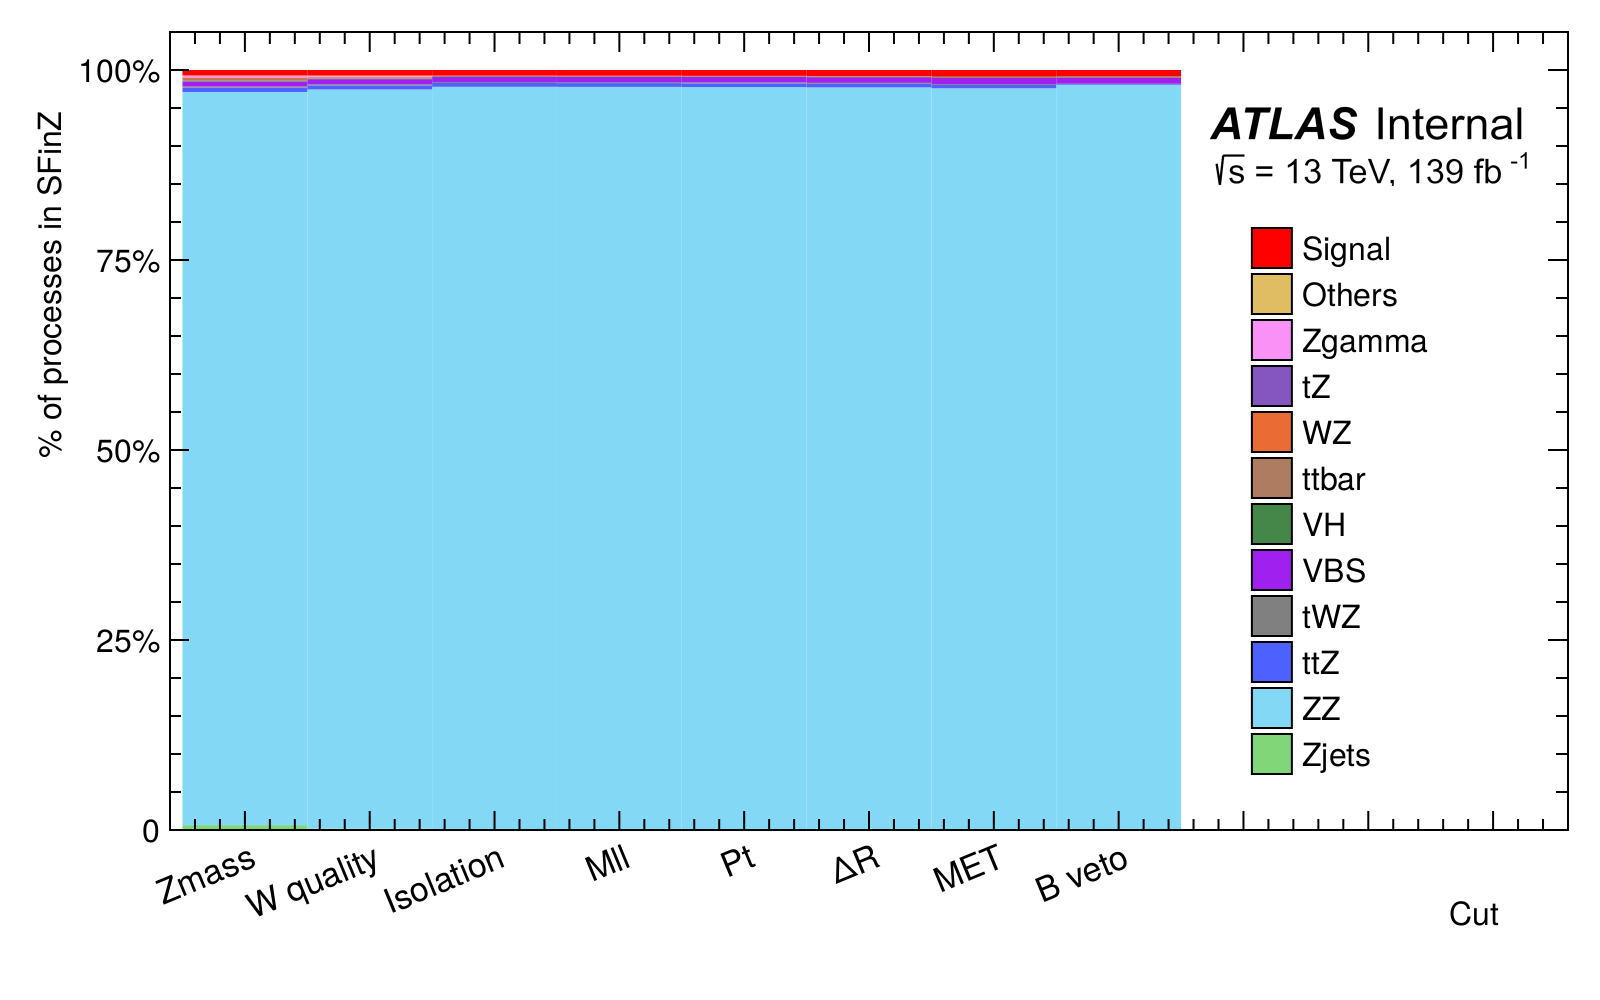

In [12]:
atlastheme=Theme(
      Axis = (
              xtickalign=1, ytickalign=1, 
              xminortickalign=1, yminortickalign=1,
              xticksize=10, yticksize=10,
              xminorticksize=6, yminorticksize=6,
              xgridvisible = false, ygridvisible = false,
              xticksmirrored=true,yticksmirrored=true,
              xminorticksvisible = true, yminorticksvisible = true,
              #xticks = WilkinsonTicks(6; k_min=4), yticks = WilkinsonTicks(7; k_min=4),
              limits = (nothing, nothing, 0, nothing), 
              xminorticks = IntervalsBetween(5), yminorticks = IntervalsBetween(5),
              font = "Helvetica"
             ),
      Colorbar = (
                  colormap = :haline,
                  highclip = :red,
                  lowclip = :black
                 )
     )

Nimbus_Bold_Italic="/home/rjacobse/fonts/NimbusSans-BoldItalic.otf"
Nimbus="/home/rjacobse/fonts/NimbusSans-Regular.otf"
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=["Zjets","ZZ","ttZ","tWZ","VBS","VH","ttbar","WZ","tZ","Zgamma","Others","Signal"]

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(SFinZcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->SFinZcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#81D678","#82D8F5","#4D61FF","#808080","#A020F0","#458749","#AD7C61","#EB6B34","#8556BF","#FA91F6","#E0BD63","#FF0000"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of processes in SFinZ",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,12), identity.(mcvalues),
            stack = repeat(1:numcuts,12),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), reverse(vcat(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 60, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    #text!("ATLAS"; position=(5.8, 0.9),  fontsize=25, font=Nimbus_Bold_Italic)
    #text!("Preliminary"; position= (6.9, 0.9), fontsize=23, font=Nimbus)
    #text!(MakieTeX.L"\sqrt{\text{s}}"; position=(5.8, 0.8),  fontsize=25,font=Nimbus)
    #text!("= 13 TeV"; position= (6.4, 0.8), fontsize=23)
    
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("SFinZCutFlow.pdf",f)
    f
end

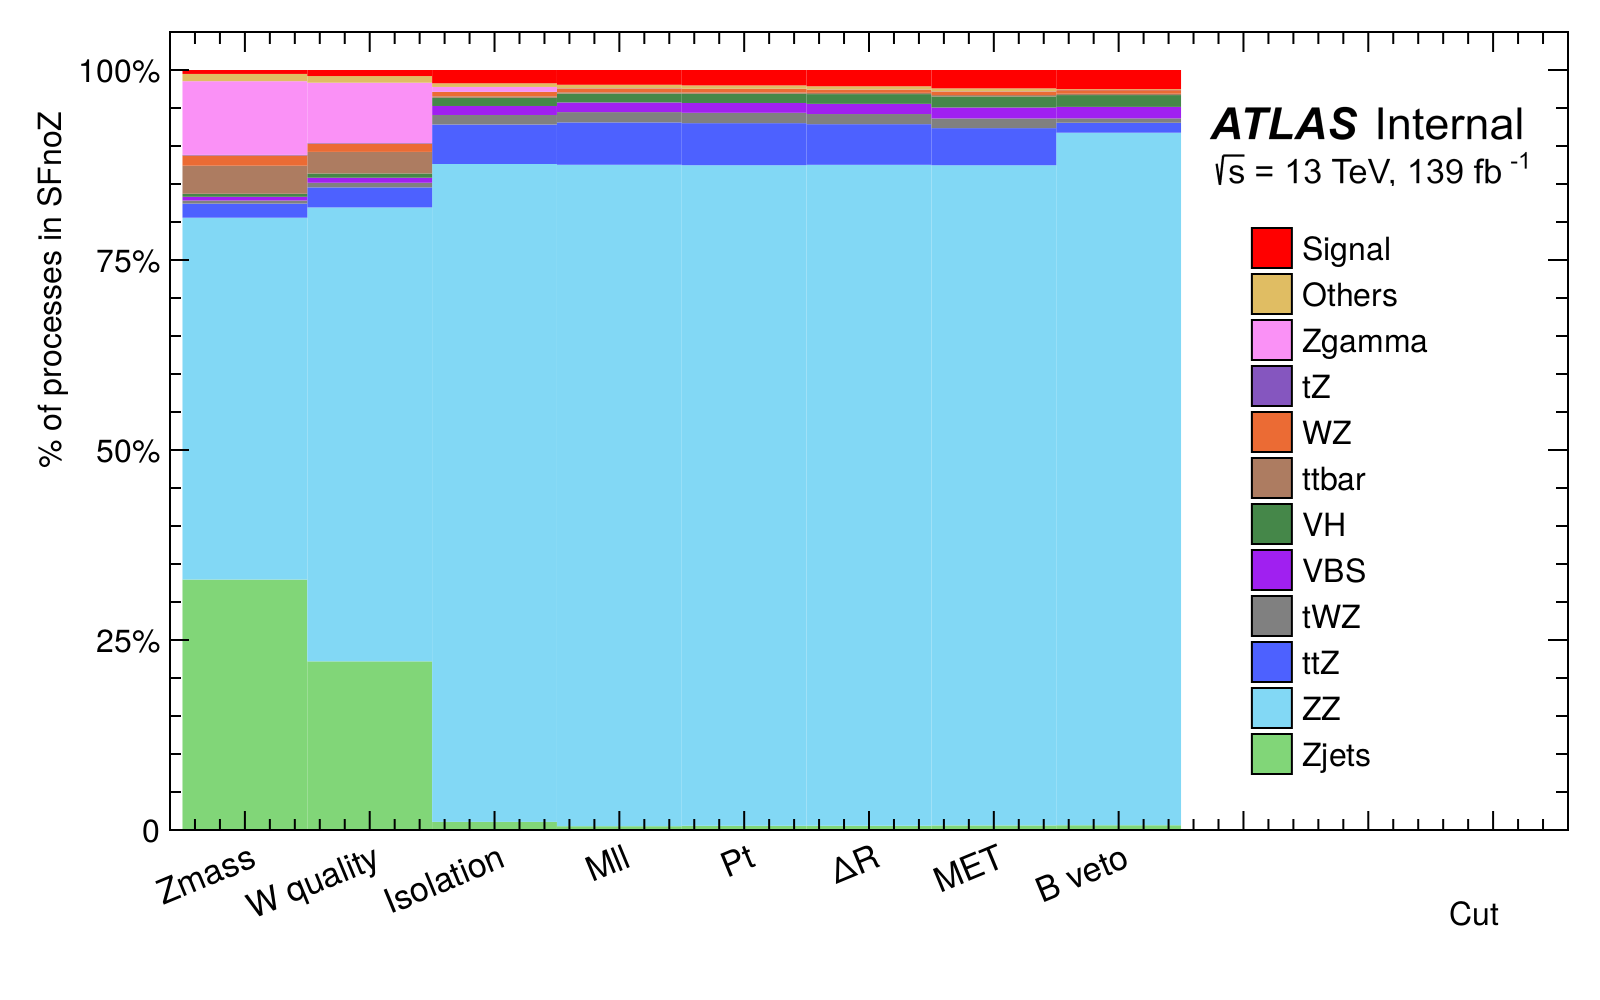

In [13]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=["Zjets","ZZ","ttZ","tWZ","VBS","VH","ttbar","WZ","tZ","Zgamma","Others","Signal"]

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(SFnoZcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->SFnoZcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#81D678","#82D8F5","#4D61FF","#808080","#A020F0","#458749","#AD7C61","#EB6B34","#8556BF","#FA91F6","#E0BD63","#FF0000"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of processes in SFnoZ",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,12), identity.(mcvalues),
            stack = repeat(1:numcuts,12),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 60, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    #text!("ATLAS"; position=(5.8, 0.9),  fontsize=25, font=Nimbus_Bold_Italic)
    #text!("Preliminary"; position= (6.9, 0.9), fontsize=23, font=Nimbus)
    #text!(MakieTeX.L"\sqrt{\text{s}}"; position=(5.8, 0.8),  fontsize=25,font=Nimbus)
    #text!("= 13 TeV"; position= (6.4, 0.8), fontsize=23)
    
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("SFnoZCutFlow.pdf",f)
    f
end

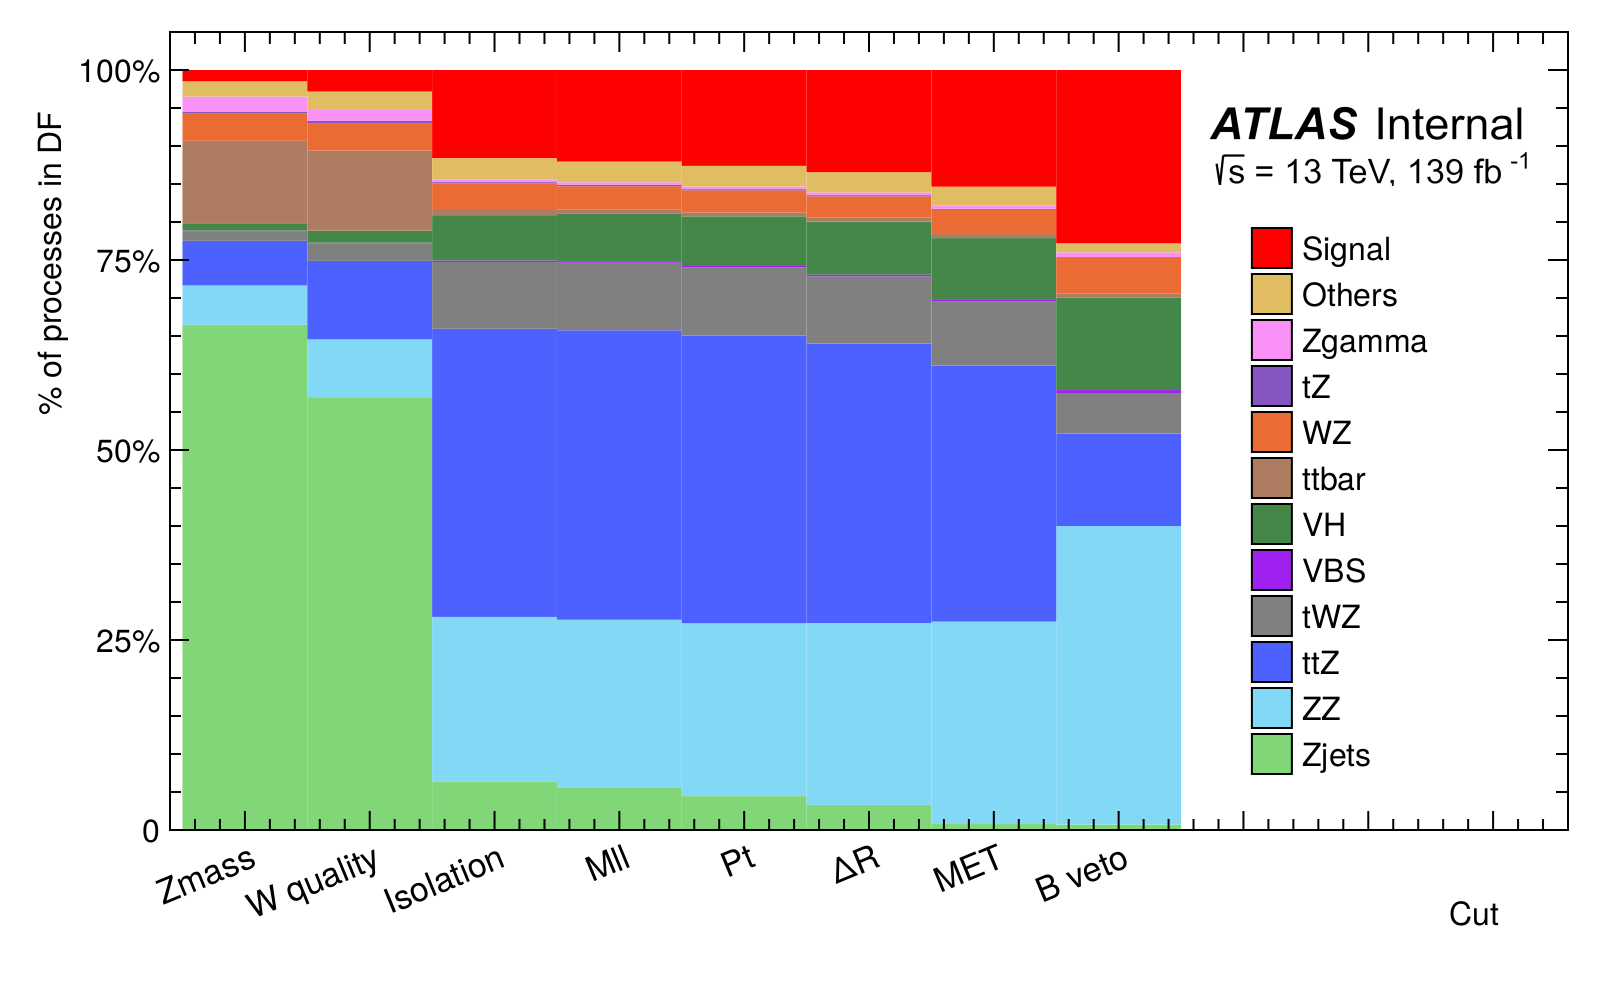

In [14]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=["Zjets","ZZ","ttZ","tWZ","VBS","VH","ttbar","WZ","tZ","Zgamma","Others","Signal"]

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(DFcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->DFcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#81D678","#82D8F5","#4D61FF","#808080","#A020F0","#458749","#AD7C61","#EB6B34","#8556BF","#FA91F6","#E0BD63","#FF0000"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of processes in DF",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,12), identity.(mcvalues),
            stack = repeat(1:numcuts,12),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 60, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    #text!("ATLAS"; position=(5.8, 0.9),  fontsize=25, font=Nimbus_Bold_Italic)
    #text!("Preliminary"; position= (6.9, 0.9), fontsize=23, font=Nimbus)
    #text!(MakieTeX.L"\sqrt{\text{s}}"; position=(5.8, 0.8),  fontsize=25,font=Nimbus)
    #text!("= 13 TeV"; position= (6.4, 0.8), fontsize=23)
    
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("DFCutFlow.pdf",f)
    f
end

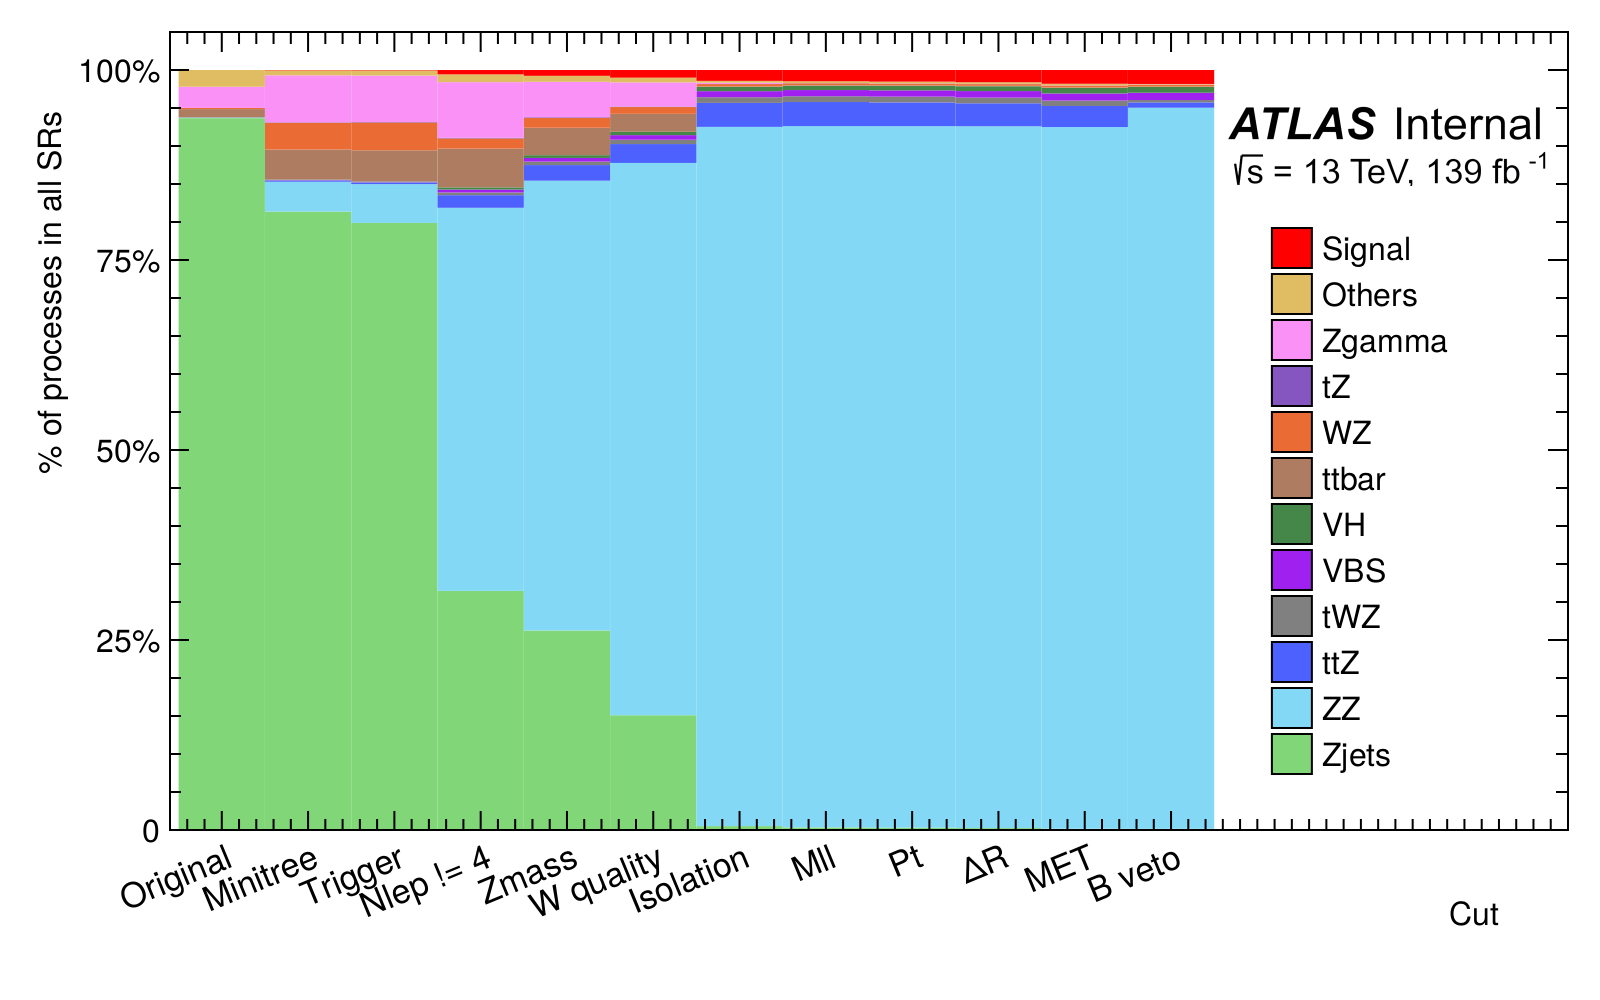

In [15]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=["Zjets","ZZ","ttZ","tWZ","VBS","VH","ttbar","WZ","tZ","Zgamma","Others","Signal"]
    CSs=[sum(CSDict["Zjets"]),
         sum(CSDict["ZZ"]),
         sum(CSDict["ttZ"]),
         sum(CSDict["tWZ"]),
         sum(CSDict["VBS"]),
         sum(CSDict["VH"]),
         sum(CSDict["ttbar"]),
         sum(CSDict["WZ"]),
         sum(CSDict["tZ"]),
         sum(CSDict["Zgamma"]),
         sum(CSDict["Others"]),
         sum(CSDict["Signal"])]
    MCCS = sum(CSs)

    numcuts=12
    for process in processescutorder
        push!(mcvalues,sum(CSDict[process])/MCCS)
        for bin in 1:numcuts-1
            push!(mcvalues,sum(bincounts(wgthists[process])[bin:numcuts])*(1/sum(sum(bincounts(mapreduce(x->wgthists[x],+,processescutorder))[bin:numcuts]))))
        end
    end


    colors=["#81D678","#82D8F5","#4D61FF","#808080","#A020F0","#458749","#AD7C61","#EB6B34","#8556BF","#FA91F6","#E0BD63","#FF0000"]
    labels = processescutorder
    xtickpos = 1:numcuts
    ticklabels = ["Original","Minitree","Trigger","Nlep != 4","Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto"]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of processes in all SRs",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+4.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,12), identity.(mcvalues),
            stack = repeat(1:numcuts,12),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 50, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(14.5,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("TotalCutFlow.pdf",f)
    f
end

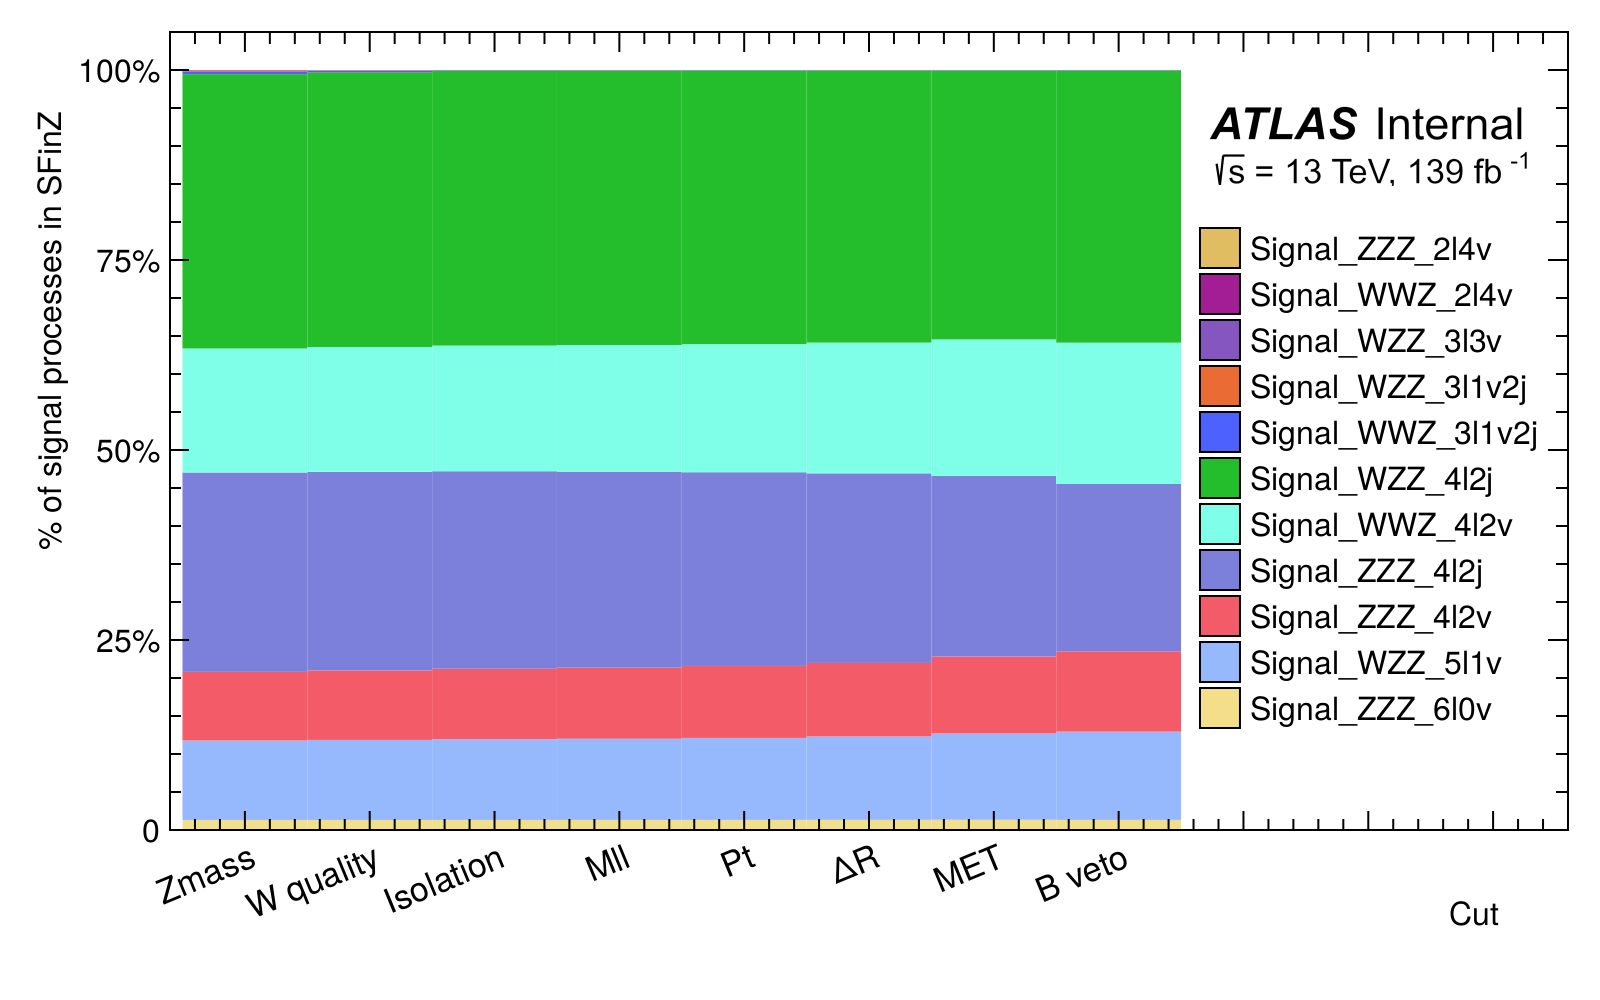

In [16]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=namessignal

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(SFinZcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->SFinZcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#F3DE8A","#95b9fc","#F45B69","#7D80DA","#80FFE8","#24bd2b","#4D61FF","#EB6B34","#8556BF","#a31d94","#E0BD63"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of signal processes in SFinZ",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,length(labels)), identity.(mcvalues),
            stack = repeat(1:numcuts,length(labels)),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 5, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("SFinZSignalCutFlow.pdf",f)
    f
end

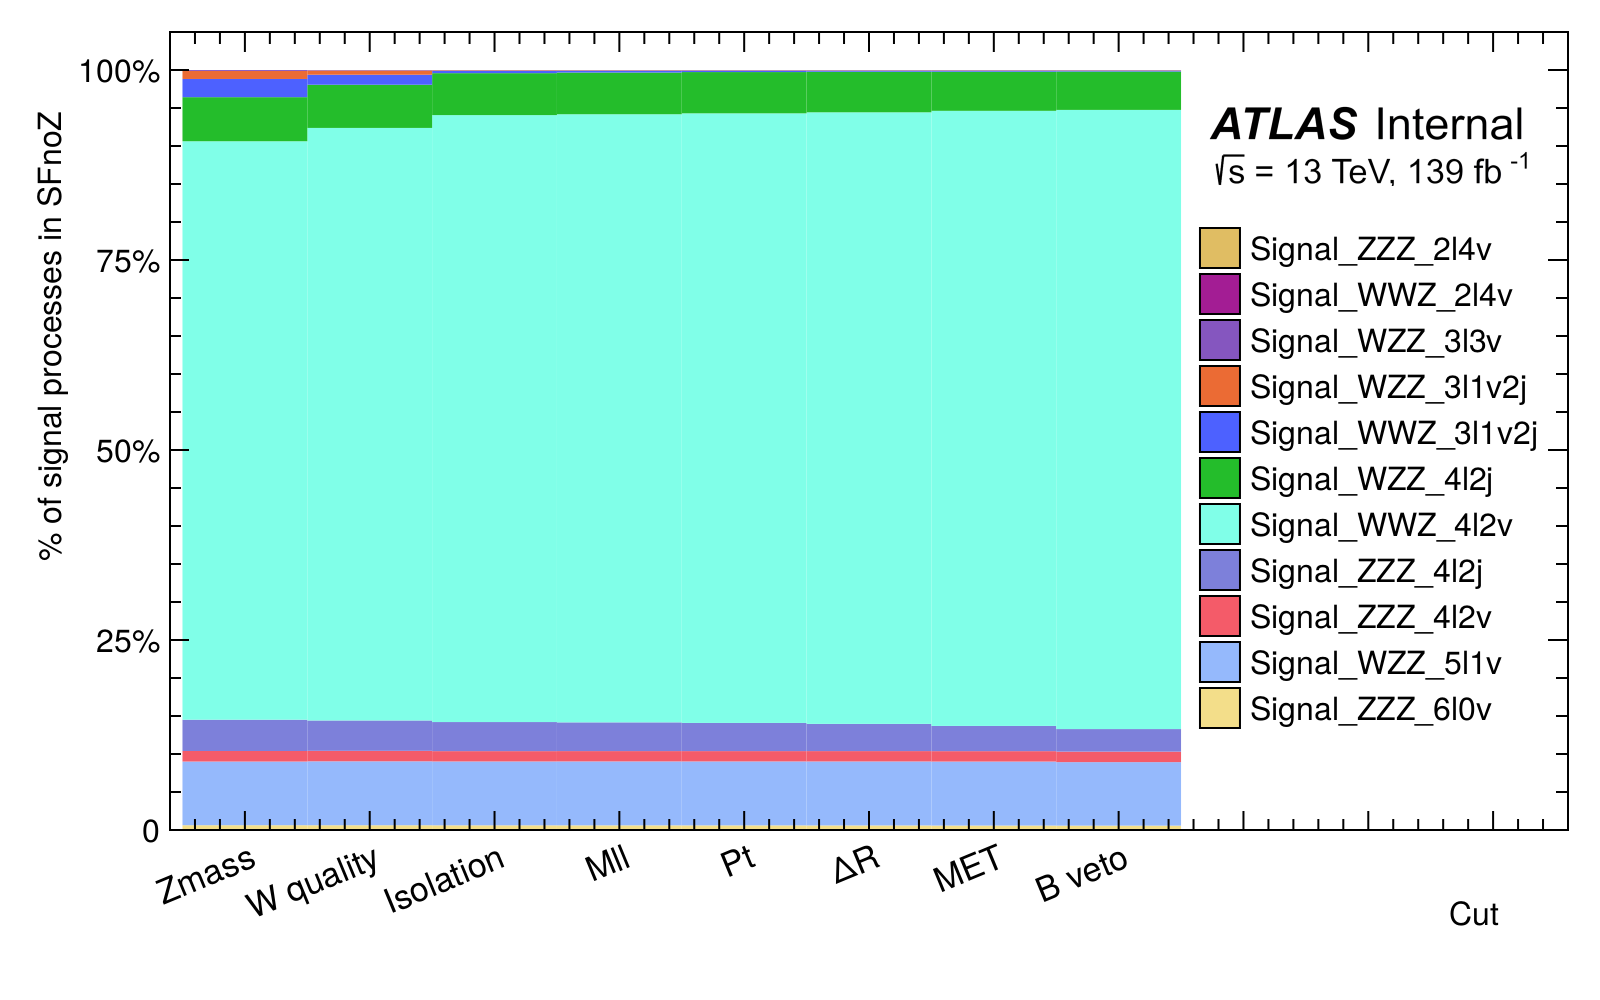

In [17]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=namessignal

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(SFnoZcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->SFnoZcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#F3DE8A","#95b9fc","#F45B69","#7D80DA","#80FFE8","#24bd2b","#4D61FF","#EB6B34","#8556BF","#a31d94","#E0BD63"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of signal processes in SFnoZ",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,length(labels)), identity.(mcvalues),
            stack = repeat(1:numcuts,length(labels)),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 5, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("SFnoZSignalCutFlow.pdf",f)
    f
end

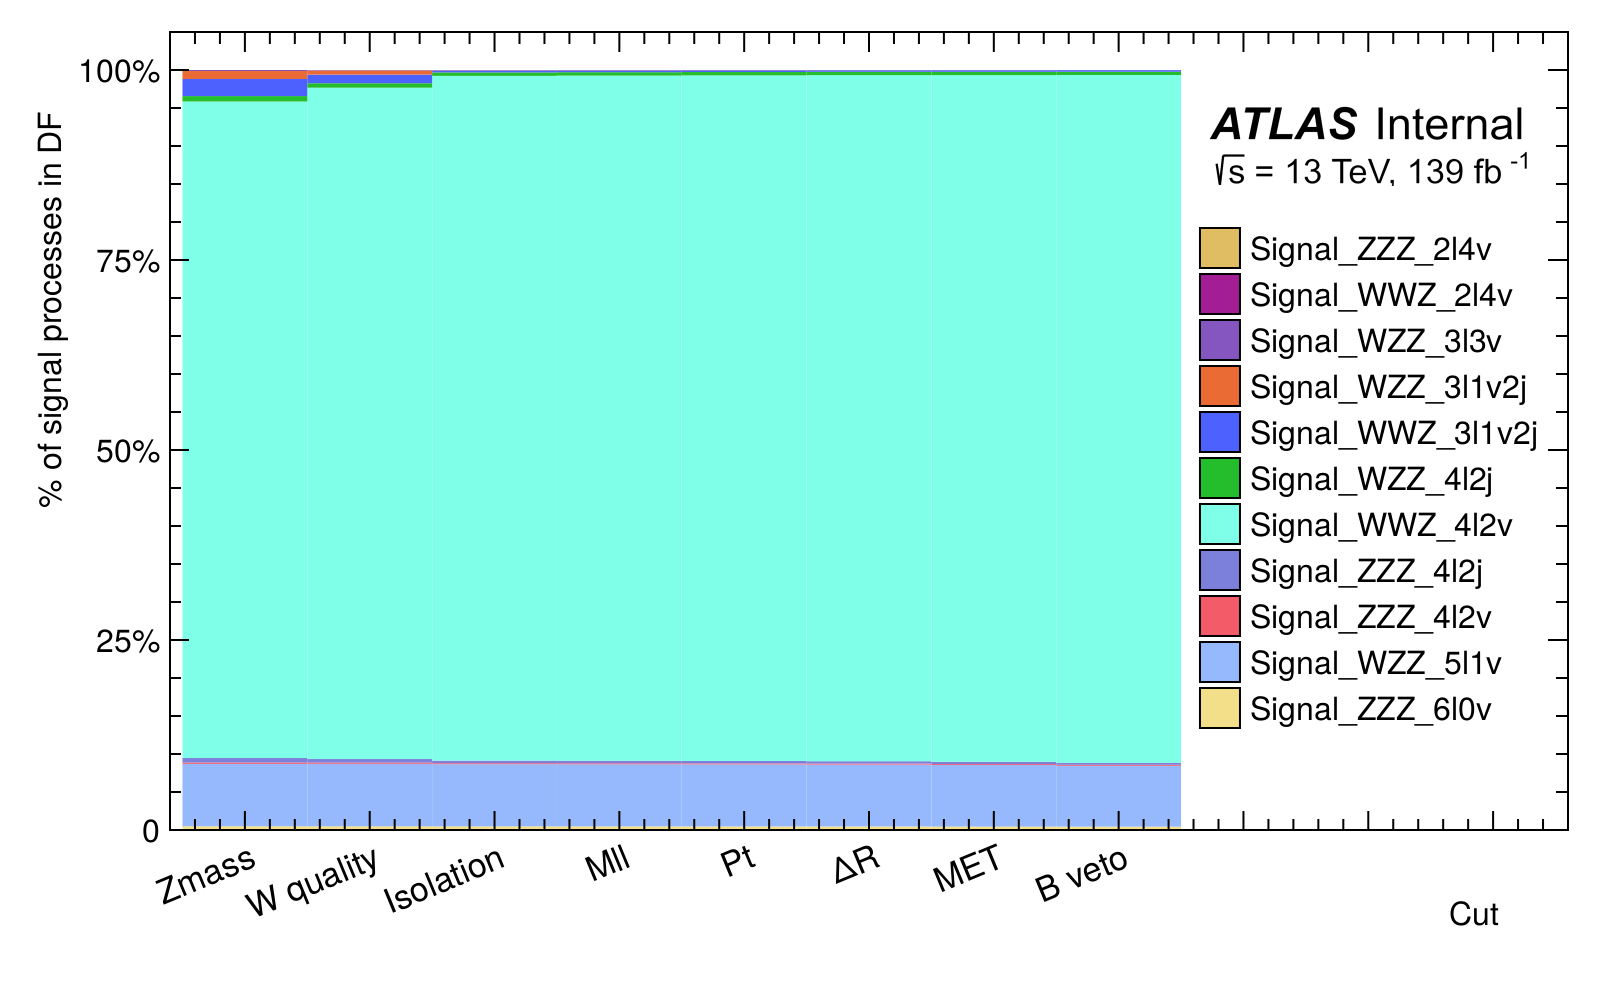

In [18]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=namessignal

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(DFcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->DFcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#F3DE8A","#95b9fc","#F45B69","#7D80DA","#80FFE8","#24bd2b","#4D61FF","#EB6B34","#8556BF","#a31d94","#E0BD63"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of signal processes in DF",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,length(labels)), identity.(mcvalues),
            stack = repeat(1:numcuts,length(labels)),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 5, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("DFSignalCutFlow.pdf",f)
    f
end

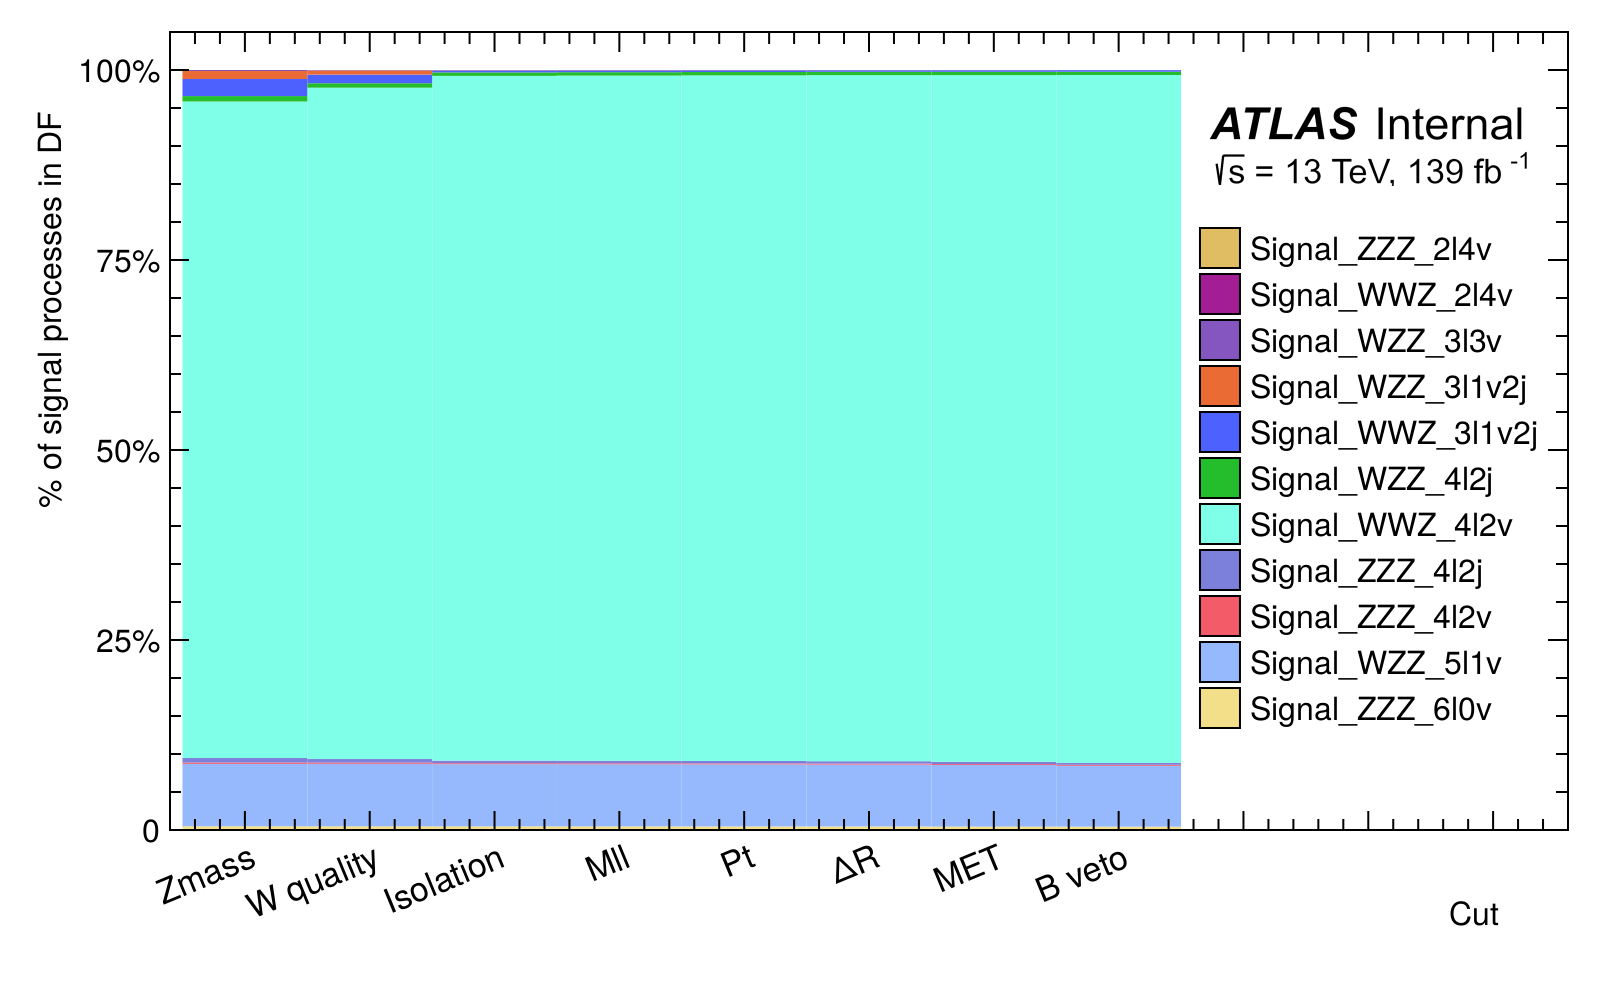

In [19]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=namessignal

    numcuts=8
    for process in processescutorder
        for bin in 1:numcuts
            push!(mcvalues,sum(bincounts(DFcutflowswgt[process])[bin+3:numcuts+3])*(1/sum(bincounts(mapreduce(x->DFcutflowswgt[x],+,processescutorder))[bin+3:numcuts+3])))
        end
    end


    colors=["#F3DE8A","#95b9fc","#F45B69","#7D80DA","#80FFE8","#24bd2b","#4D61FF","#EB6B34","#8556BF","#a31d94","#E0BD63"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
    ticklabels = ["Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of signal processes in DF",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+3.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,length(labels)), identity.(mcvalues),
            stack = repeat(1:numcuts,length(labels)),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 5, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(10,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("DFSignalCutFlow.pdf",f)
    f
end

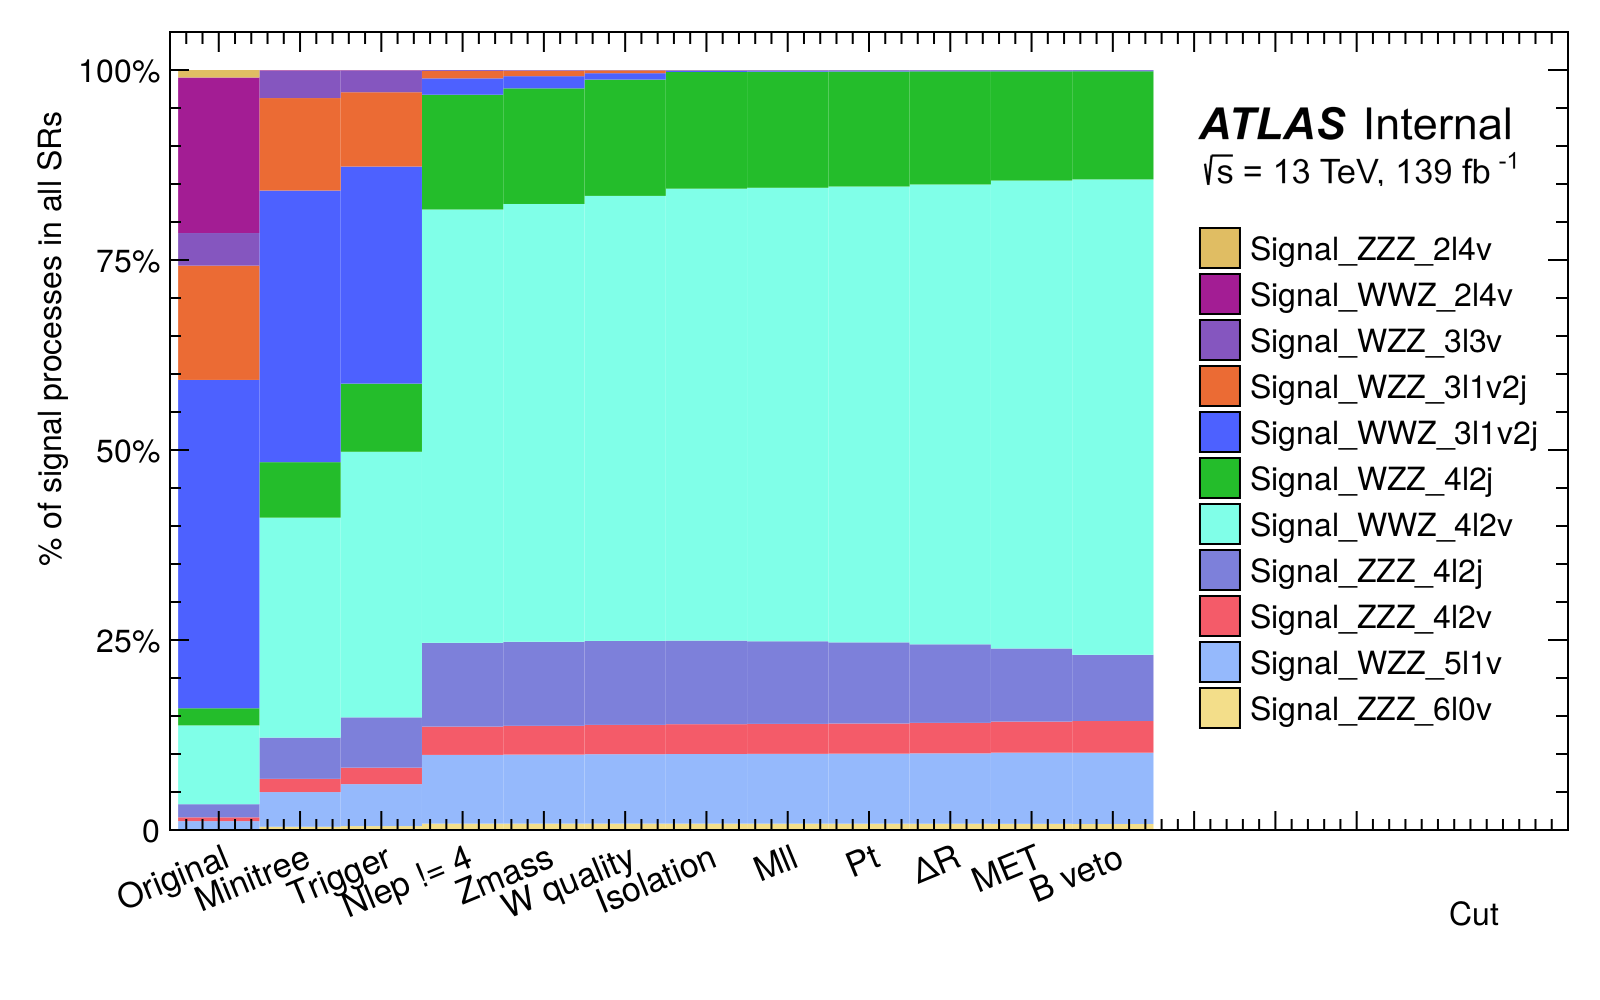

In [20]:
with_theme(atlastheme) do

    variable = :cut
    mcvalues = []
    sigvalues = []

    processescutorder=namessignal
    CSs=[sum(CSDict["Signal_ZZZ_6l0v"]),
         sum(CSDict["Signal_WZZ_5l1v"]),
         sum(CSDict["Signal_ZZZ_4l2v"]),
         sum(CSDict["Signal_ZZZ_4l2j"]),
         sum(CSDict["Signal_WWZ_4l2v"]),
         sum(CSDict["Signal_WZZ_4l2j"]),
         sum(CSDict["Signal_WWZ_3l1v2j"]),
         sum(CSDict["Signal_WZZ_3l1v2j"]),
         sum(CSDict["Signal_WZZ_3l3v"]),
         sum(CSDict["Signal_WWZ_2l4v"]),
         sum(CSDict["Signal_ZZZ_2l4v"])]
    MCCS = sum(CSs)

    numcuts=12
    for process in processescutorder
        push!(mcvalues,sum(CSDict[process])/MCCS)
        for bin in 1:numcuts-1
            push!(mcvalues,sum(bincounts(wgthists[process])[bin:numcuts])*(1/sum(bincounts(mapreduce(x->wgthists[x],+,processescutorder))[bin:numcuts])))
        end
    end



    colors=["#F3DE8A","#95b9fc","#F45B69","#7D80DA","#80FFE8","#24bd2b","#4D61FF","#EB6B34","#8556BF","#a31d94","#E0BD63"]
    labels = processescutorder
    xtickpos = 1:numcuts+3
ticklabels = ["Original","Minitree","Trigger","Nlep != 4","Zmass","W quality","Isolation","Mll","Pt","ΔR","MET","B veto","","",""]

    f=Figure(resolution=(800,500))
    a = Axis(f[1, 1], yscale = identity, ylabel = "% of signal processes in all SRs",
            xlabel="Cut",# xlabelalign=(:left,:center),
            yticks = ([0,1/4,1/2,3/4,1],["0","25%","50%","75%","100%"]),
            xticks = (xtickpos, ticklabels),xticklabelsize=17,
            xticklabelrotation = pi/8)

    xlims!(0.4,numcuts+5.6)
    ylims!(0,nothing)

    barplot!(repeat(1:numcuts,length(labels)), identity.(mcvalues),
            stack = repeat(1:numcuts,length(labels)),
            color = repeat(colors,inner=numcuts),
            width = 1.25)

    #creates legend
    elements = [PolyElement(polycolor = reverse(colors)[i],strokecolor=:black,strokewidth =1) for i in 1:length(labels)]
    axislegend(a,vcat(elements), vcat(reverse(labels)),
        tellheight = false,
        tellwidth = true,
        margin = (30, 5, 50, 90),
        halign = :right, orientation = :vertical, framevisible = false,
    )
    img = load("/home/rjacobse/atlasinternal.png")
    scatter!(15,0.9,marker=img,markersize=(160,40))
    move_xlabel!(a)
    move_ylabel!(a)
    save("TotalSignalCutFlow.pdf",f)
    f
end

In [21]:
variable = :cut
backgrounds=namesmain[1:end]
cuts = ["Original","Minitree","Trigger","Nlep != 4","Zmass","W quality","Isolation","Mll","Pt",raw"$\Delta$ R","MET","B veto"]
cutvalues = Dict()

numcuts=12
for process in namesmain
    cutvalues[process]=[]
    push!(cutvalues[process],sum(CSDict[process]))
    for bin in 1:numcuts-1
        push!(cutvalues[process],sum(bincounts(wgthists[process])[bin:numcuts]))
    end
end
cutvalues["Significance"]=[]
for bin in 1:numcuts
    push!(cutvalues["Significance"],cutvalues["Signal"][bin]/sqrt(mapreduce(x->cutvalues[x][bin],+,backgrounds)))
end

cutvalues["QuadSignificance"]=[]
for bin in 1:numcuts
    SFinZsig=bincounts(SFinZcutflowswgt["Signal"])[bin]/sqrt(mapreduce(x->bincounts(SFinZcutflowswgt[x])[bin],+,backgrounds))
    SFnoZsig=bincounts(SFnoZcutflowswgt["Signal"])[bin]/sqrt(mapreduce(x->bincounts(SFnoZcutflowswgt[x])[bin],+,backgrounds))
    DFsig=bincounts(DFcutflowswgt["Signal"])[bin]/sqrt(mapreduce(x->bincounts(DFcutflowswgt[x])[bin],+,backgrounds))
    push!(cutvalues["QuadSignificance"],sqrt(SFinZsig^2+SFnoZsig^2+DFsig^2))
end

Cutflow by process and signal subprocess:

In [22]:
tablename="4l-cutflow-1";
subtitle=raw"Expected cut flow for all processes for $4\ell$ channel for $139\;\textrm{fb}^{-1}$, part 1.";
numcolumns=8
print(
raw"""\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c""")
for i in 1:numcolumns
    print(raw"|c")
end
println(raw"}")
println(raw"\hline \hline")
processes=["Zjets","ZZ","ttZ","tWZ","VBS","VH","ttbar","WZ","tZ","Zgamma","Others","Signal"]
print("Cut Name")
for process in processes[1:8]
    print(" & ")
    print(process)
end
print(raw"\\ ")
println()
println(raw"\hline \hline")
for i in 1:numcuts
    print(cuts[i])
    for process in processes[1:8]
        print("  &  ")
        print(format(round(cutvalues[process][i],digits=2), commas=true))
    end
    println(raw" \\ ")
end
println(
raw"""\hline \hline
\end{tabular}
}""")
print(raw"\caption{")
print(subtitle)
println(raw"}")
print(raw"\label{tab:")
print(tablename)
println(raw"}")
println(raw"\end{table}")

\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c|c|c|c|c|c|c|c|c}
\hline \hline
Cut Name & Zjets & ZZ & ttZ & tWZ & VBS & VH & ttbar & WZ\\ 
\hline \hline
Original  &  926,456,179.22  &  684,360.32  &  110,273.6  &  2,233.31  &  22,866.61  &  236,632.71  &  10,685,848.51  &  1,523,781.11 \\ 
Minitree  &  2,398,942.64  &  115,599.25  &  5,002.34  &  1,001.35  &  1,322.52  &  1,175.86  &  116,631.59  &  104,020.2 \\ 
Trigger  &  1,123,584.92  &  71,895.08  &  3,004.57  &  610.21  &  774.51  &  669.51  &  57,586.33  &  51,523.43 \\ 
Nlep != 4  &  19,913.03  &  31,897.18  &  1,050.14  &  225.61  &  242.25  &  183.27  &  3,225.41  &  849.85 \\ 
Zmass  &  10,459.18  &  23,581.17  &  819.47  &  182  &  192.7  &  143.82  &  1,438.42  &  514.28 \\ 
W quality  &  3,714.25  &  17,872.15  &  611.06  &  140.12  &  148.49  &  107.64  &  581.97  &  219.65 \\ 
Isolation  &  71.21  &  12,762.61  &  437.5  &  104.25  &  109.97  &  77  &  10.74  &  41.84 \\ 
Mll  &  37.45  &

In [23]:
tablename="4l-cutflow-2";
subtitle=raw"Expected cut flow for all processes for $4\ell$ channel for $139\;\textrm{fb}^{-1}$, part 2.";
numcolumns=7
print(
raw"""\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c""")
for i in 1:numcolumns
    print(raw"|c")
end
println(raw"}")
println(raw"\hline \hline")
processes=["Zjets","ZZ","ttZ","tWZ","VBS","VH","ttbar","WZ","tZ","Zgamma","Others","Signal"]
print("Cut Name")
for process in processes[9:12]
    print(" & ")
    print(process)
end
print(" & ")
print("Tot. Bkg.")
print(" & ")
print("Tot. Sign.")
print(" & ")
print("Quad. Sign.")
print(raw"\\ ")
println()
println(raw"\hline \hline")
for i in 1:numcuts
    print(cuts[i])
    for process in processes[9:12]
        print("  &  ")
        print(format(round(cutvalues[process][i],digits=2), commas=true))
    end
    print(" & ")
    print(totvalues["Yield after cut"][i])
    print(" & ")
    print(format(round(cutvalues["Significance"][i],digits=2), commas=true))
    print(" & ")
    if i < 5
        print(raw"N/A")
    else
        print(format(round(cutvalues["QuadSignificance"][i-1],digits=2), commas=true))
    end
    println(raw" \\ ")
end

println(
raw"""\hline \hline
\end{tabular}
}""")
print(raw"\caption{")
print(subtitle)
println(raw"}")
print(raw"\label{tab:")
print(tablename)
println(raw"}")
println(raw"\end{table}")

\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c|c|c|c|c|c|c|c}
\hline \hline
Cut Name & tZ & Zgamma & Others & Signal & Tot. Bkg. & Tot. Sign. & Quad. Sign.\\ 
\hline \hline
Original  &  33,408.62  &  27,546,445.61  &  21,796,989.41  &  2,408.55 & 989,099,019.02 & 0.08 & N/A \\ 
Minitree  &  1,653.74  &  182,075.95  &  19,291.24  &  1,366.67 & 2,946,716.68 & 0.8 & N/A \\ 
Trigger  &  844.17  &  85,934.57  &  9,433.02  &  860.87 & 1,405,860.3 & 0.73 & N/A \\ 
Nlep != 4  &  56.34  &  4,630.6  &  646.72  &  363.43 & 62,920.41 & 1.44 & N/A \\ 
Zmass  &  35.37  &  1,856.54  &  316.11  &  304.92 & 39,539.05 & 1.53 & 0.52 \\ 
W quality  &  15.58  &  781.89  &  152.89  &  248.03 & 24,345.69 & 1.58 & 0.53 \\ 
Isolation  &  2.06  &  22.88  &  33.8  &  198.17 & 13,673.87 & 1.68 & 1.14 \\ 
Mll  &  1.54  &  1.8  &  25.22  &  163.93 & 10,877.3 & 1.56 & 1.18 \\ 
Pt  &  1.11  &  1.29  &  18.92  &  129.9 & 8,346.99 & 1.41 & 1.2 \\ 
$\Delta$ R  &  0.77  &  0.88  &  12.91  

In [24]:
variable = :cut
processnames = namessignal
cuts = ["Original","Minitree","Trigger","Nlep != 4","Zmass","W quality","Isolation","Mll","Pt",raw"$\Delta$ R","MET","B veto"]
cutvalues = Dict()

numcuts=12
for process in processnames
    cutvalues[process]=[]
    push!(cutvalues[process],sum(CSDict[process]))
    for bin in 1:numcuts-1
        push!(cutvalues[process],bincounts(wgthists[process])[bin])
    end
end

In [25]:
tablename="4l-cutflow-1";
subtitle=raw"Expected cut flow for signal subprocesses for $4\ell$ channel for $139\;\textrm{fb}^{-1}$, part 1.";
numcolumns=7
print(
raw"""\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c""")
for i in 1:numcolumns
    print(raw"|c")
end
println(raw"}")
println(raw"\hline \hline")
processes=processnames
print("Cut Name")
for process in processes[1:6]
    print(" & ")
    print(replace(replace(process,"_"=>" "),"Signal"=>""))
end
print(raw"\\ ")
println()
println(raw"\hline \hline")
for i in 1:numcuts
    print(cuts[i])
    for process in processes[1:6]
        print("  &  ")
        print(format(round(cutvalues[process][i],digits=2), commas=true))
    end
    println(raw" \\ ")
end
println(
raw"""\hline \hline
\end{tabular}
}""")
print(raw"\caption{")
print(subtitle)
println(raw"}")
print(raw"\label{tab:")
print(tablename)
println(raw"}")
println(raw"\end{table}")

\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c|c|c|c|c|c|c|c}
\hline \hline
Cut Name &  ZZZ 6l0v &  WZZ 5l1v &  ZZZ 4l2v &  ZZZ 4l2j &  WWZ 4l2v &  WZZ 4l2j\\ 
\hline \hline
Original  &  2.02  &  26.14  &  12.01  &  41.66  &  249.66  &  54.32 \\ 
Minitree  &  1.4  &  14.82  &  5.13  &  17.18  &  94.72  &  22.61 \\ 
Trigger  &  1.4  &  14.68  &  5.07  &  16.96  &  93.58  &  22.34 \\ 
Nlep != 4  &  0.48  &  5.17  &  1.99  &  6.34  &  31.56  &  8.47 \\ 
Zmass  &  0.47  &  5.03  &  1.99  &  6.31  &  30.42  &  8.43 \\ 
W quality  &  0.42  &  4.51  &  1.78  &  5.61  &  27.41  &  7.53 \\ 
Isolation  &  0.29  &  3.1  &  1.32  &  3.97  &  20.02  &  5.39 \\ 
Mll  &  0.29  &  3.09  &  1.31  &  3.95  &  19.9  &  5.38 \\ 
Pt  &  0.29  &  3.07  &  1.3  &  3.94  &  19.79  &  5.35 \\ 
$\Delta$ R  &  0.29  &  3.07  &  1.3  &  3.94  &  19.78  &  5.35 \\ 
MET  &  0.27  &  3.01  &  1.29  &  3.37  &  19.48  &  4.66 \\ 
B veto  &  0.24  &  2.83  &  1.26  &  2.63  &  18.87  & 

In [26]:
tablename="4l-cutflow-2";
subtitle=raw"Expected cut flow for signal subprocesses for $4\ell$ channel for $139\;\textrm{fb}^{-1}$, part 1.";
numcolumns=7
print(
raw"""\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c""")
for i in 1:numcolumns
    print(raw"|c")
end
println(raw"}")
println(raw"\hline \hline")
processes=processnames
print("Cut Name")
for process in processes[7:11]
    print(" & ")
    print(replace(replace(process,"_"=>" "),"Signal"=>""))
end
print(raw"\\ ")
println()
println(raw"\hline \hline")
for i in 1:numcuts
    print(cuts[i])
    for process in processes[7:11]
        print("  &  ")
        print(format(round(cutvalues[process][i],digits=2), commas=true))
    end
    println(raw" \\ ")
end
println(
raw"""\hline \hline
\end{tabular}
}""")
print(raw"\caption{")
print(subtitle)
println(raw"}")
print(raw"\label{tab:")
print(tablename)
println(raw"}")
println(raw"\end{table}")

\begin{table}[!htbp]
\centering
\resizebox{\columnwidth}{!}{
\begin{tabular}{c|c|c|c|c|c|c|c}
\hline \hline
Cut Name &  WWZ 3l1v2j &  WZZ 3l1v2j &  WZZ 3l3v &  WWZ 2l4v &  ZZZ 2l4v\\ 
\hline \hline
Original  &  1,040.54  &  362.11  &  103.44  &  492.87  &  23.79 \\ 
Minitree  &  242.53  &  82.13  &  24.76  &  0.45  &  0.06 \\ 
Trigger  &  238.06  &  80.62  &  24.27  &  0.4  &  0.05 \\ 
Nlep != 4  &  2.96  &  1.35  &  0.17  &  0  &  0 \\ 
Zmass  &  2.8  &  1.28  &  0.15  &  0  &  0 \\ 
W quality  &  1.68  &  0.84  &  0.09  &  0  &  0 \\ 
Isolation  &  0.12  &  0.02  &  0.01  &  0  &  0 \\ 
Mll  &  0.09  &  0.02  &  0  &  0  &  0 \\ 
Pt  &  0.08  &  0.01  &  0  &  0  &  0 \\ 
$\Delta$ R  &  0.04  &  0.01  &  0  &  0  &  0 \\ 
MET  &  0.04  &  0.01  &  0  &  0  &  0 \\ 
B veto  &  0.04  &  0.01  &  0  &  0  &  0 \\ 
\hline \hline
\end{tabular}
}
\caption{Expected cut flow for signal subprocesses for $4\ell$ channel for $139\;\textrm{fb}^{-1}$, part 1.}
\label{tab:4l-cutflow-2}
\end{table}